# Automated Discovery of Temperature Dependent Structural Change

    Neutron powder diffraction is a powerful way to examine the atomic structure of technologically interesting materials. The particular material from this data set is a candidate for solar cells . Nevertheless, the same methods are used in battery materials, catalysts, etc. A single data set has 2 dimensions: Intensity(I) and d spacing (d). The d spacing is a characteristic structural scale in the system. If there is a large I at a given d, that means there are at least two atoms spaced at that distance in the system. If I is at the background it means there is nothing with that d spacing in the material.
    
    Often functional behavior is related to a structural change with an external parameter like temperature. This structural change show up as change in the existence, position or width of the peaks. The provided data set is a collection of I vs d curves at multiple temperatures. So the data set is 3 dimensional I(d,T). The data is in an HDF5 file. H5py is a useful set of libraries for accessing HDF5 files from python. If you are not familiar with hdf5 and want to browse the data structure want to browse the data structure we recommend hdfview or nexpy. However, the developed algorithms should run independently of these codes.

# Challenge
    Given the aforementioned data set, here are the challenge questions
    
    1. Provide an algorithm that given the data set as an input, provides the temperature of the structural transition.
    2. Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for the peak that is between 3.2 and 3.3 Å in d spacing as a function of temperature.
    3. Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for all peaks at a given Temperature.
    4. Given adjacent temperatures, provide an algorithm that indicates if a phase transition occurred between the two temperatures, a list of centers, widths, and intensities for all peaks in the data set that are at least 1.5x above background in under 5 seconds

    Our preference is for the algorithms to be implemented in Python with use of the numpy library, other necessary libraries are welcome. If the participant prefers a compiled code, C/C++, is our preferred solution with the output being in a python or numpy data structure.

In [1]:
import numpy as np
import scipy as sp

#import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
#%matplotlib notebook
%matplotlib inline
mpl.rcParams['savefig.dpi'] = 300

from nexusformat.nexus import *
import warnings
warnings.filterwarnings('ignore')

from IPython.core.pylabtools import figsize
np.set_printoptions(precision=3)

from matplotlib import rc
rc('text', usetex=True)

import os
os.makedirs('Q4/Data/', exist_ok=True)
os.makedirs('Q4/Figs/', exist_ok=True)

# Q0. Load the data, and convert the data into np arrays. 

In [2]:
ff = nxload('NPD_Temp.nxs')
data = ff.entry.data

'''to keep the nexus format. The data format are slightly difffernt to np array.'''
#_intsy = data['intensity']
#_QQs = data['Q']
#_dds = data['dspacing']
#_temps = data['temperature']

'''convert to numpy array'''
intsy = np.asarray(data['intensity'])
QQs = np.asarray(data['Q'])
dds = np.asarray(data['dspacing'])
temps = np.asarray(data['temperature'])
dd_cs = (dds[:-1]+dds[1:])/2
temp_cs = (temps[:-1]+ temps[1:])/2


# Q4 Given adjacent temperatures, provide an algorithm that indicates if a phase transition occurred between the two temperatures, a list of centers, widths, and intensities for all peaks in the data set that are at least 1.5x above background in under 5 seconds.

## 4.1 Using DBSCAN to find the signal points, which are used to determine the similarity between them. Based on this information, we calcuate the likehood of a phase transtion between these two temperatures. 

    * Overall, the accuracy of phase transion prediction based on just two datasets is much lower than using the global information, as illustrated in Q1. 
    

In [3]:
from numba import jit

#@jit
def cal_likehood(intsy, pars, par0, par1=-1, bin_cs = [], figtitle = '', 
                 nnpts=3, gamma = 5):
    '''
    calcualte the structure phase transiton likehood between two temperatures. 
    If temp1 is not given, then use the next higher temperature, unless temp0 is maximum
    temperautre in the dataset.  In the lastter case, calculate the next lower temperature.  
    nnpt: number of neighbor points to be included in each side. 
    
    add a sensitive factor gamma (default = 6).  larger, more sensitive to small change
    '''
    from sklearn.cluster import DBSCAN
    import numpy as np
    _, nbins = intsy.shape
    
    ii = (abs(pars - par0)).argmin()
    if par1 > 0:
        jj = (abs(pars - par1)).argmin()
    elif ii == len(pars)-1:
        jj = ii-1
    else:
        jj = ii+1
    
    data_0 = intsy[ii, :].flatten()
    data_1 = intsy[jj, :].flatten()
    xx, yy = np.meshgrid(np.arange(nbins), [0])
    pnt_loc = np.vstack((xx.flatten(), yy.flatten())).T

    bkg0 = np.percentile(data_0, 50)
    bkg1 = np.percentile(data_1, 50)
    ncutoff = (2 * nnpts + 1) * 1.75   # n * background
    db0 = DBSCAN(eps = nnpts, min_samples = bkg0*ncutoff, 
                 n_jobs=-1).fit(pnt_loc, sample_weight = data_0)
    db1 = DBSCAN(eps = nnpts, min_samples = bkg1*ncutoff, 
                 n_jobs=-1).fit(pnt_loc, sample_weight = data_1)

    coreloc_0 = pnt_loc[db0.labels_ != -1][:, 0]
    coreloc_1 = pnt_loc[db1.labels_ != -1][:, 0]
    #print(ii, jj, par0, par1, len(coreloc_0), len(coreloc_1))
    likehood = _likehood(coreloc_0, coreloc_1, gamma)
 
    if len(bin_cs) == nbins :
        mpl.rcParams['savefig.dpi'] = 600
        par0, par1 = pars[ii], pars[jj]
        _par0 = '%5.2f' %par0 + ' K'
        _par1 = '%5.2f' %par1 + ' K'
        print(par0, par1)
        data0_sqrt = np.sqrt(data_0)
        data1_sqrt = np.sqrt(data_1)
        plt.plot(bin_cs, data0_sqrt, color='blue', linewidth=1)
        plt.plot(bin_cs, data1_sqrt+20, color ='black', linewidth=1)
        offset = -0.1 * data0_sqrt.max()
        plt.plot(bin_cs[coreloc_0], np.full(len(coreloc_0), offset*2), '|', color = 'blue', label = _par0)
        plt.plot(bin_cs[coreloc_1], np.full(len(coreloc_1), offset), '|', markersize =4, 
                 color = 'black', label = _par1)
        
        
        plt.xlabel('d-spacing (\AA)')
        plt.ylabel('intensity ()')
        _title = 'phase transition likehood: %3.2e' %(likehood)
        plt.title(_title)
        #_ylims = (min(par0, par1)-2, max(par0, par1)+2)
        #plt.ylim(_ylims)
        plt.legend(loc=1, frameon=False)
        if len(figtitle) > 0:
            plt.savefig(figtitle)
        
    
    return  likehood

#@jit
def cal_NNlikehood_fullT(intsy, nnpts=3, gamma = 6):
    '''
    calcualte the structure phase transiton likehood between adjacent temperatures from the 
    2D NPD data. 
    
    nnpts: neighboring point used to calcuate the signal point above background. 
    gamma, sensitive factor, more sensitive to small changes.
    '''
    from sklearn.cluster import DBSCAN
    
    npars, nbins = intsy.shape 
    ncutoff = (2 * nnpts + 1) * 2
    
    xx, yy = np.meshgrid(np.arange(nbins), [0])
    pnt_loc = np.vstack((xx.flatten(), yy.flatten())).T
    
    coreloc = []
    for ii in range(npars):
        data = intsy[ii, :].flatten()
        bkg = np.percentile(data, 50)
        db = DBSCAN(eps = nnpts, min_samples = bkg*ncutoff, 
                 n_jobs=-1).fit(pnt_loc, sample_weight = data)
        coreloc.append(pnt_loc[db.labels_ != -1][:, 0])
    
    NNlikehood = []
    for ii in range(npars-1):
        NNlikehood.append(_likehood(coreloc[ii], coreloc[ii+1], gamma))
 
    return  NNlikehood

@jit
def _likehood(coreloc0, coreloc1, gamma):
    '''
    a likehood function to describe the probability of a phase transition happended 
    between the two datasets by comparsion the different core members.
    
    nnpts: neighboring point used to calcuate the signal point above background. 
    gamma, sensitive factor, more sensitive to small changes.
    '''
    core0, core1 = set(coreloc0), set(coreloc1)
    
    comm = core0 & core1 
    ntot, ncomm = len(core0) + len(core1), len(comm)
    ndiff = ntot - 2 * ncomm
    #print(ntot, ncomm, ndiff)
    if ncomm == 0 & ndiff != 0:
        likehood = 1
    else:
        reg = np.tan((ndiff/ntot - 0.5 ) * np.pi)
        #print(ntot, ncomm, ndiff, ndiff/ntot, reg)
        likehood = 1/(1 + np.exp(-(reg+gamma)))
        
    return likehood


166.99425 169.023916667
The likehood of a phase transtion at 167 K is 9.44e-01


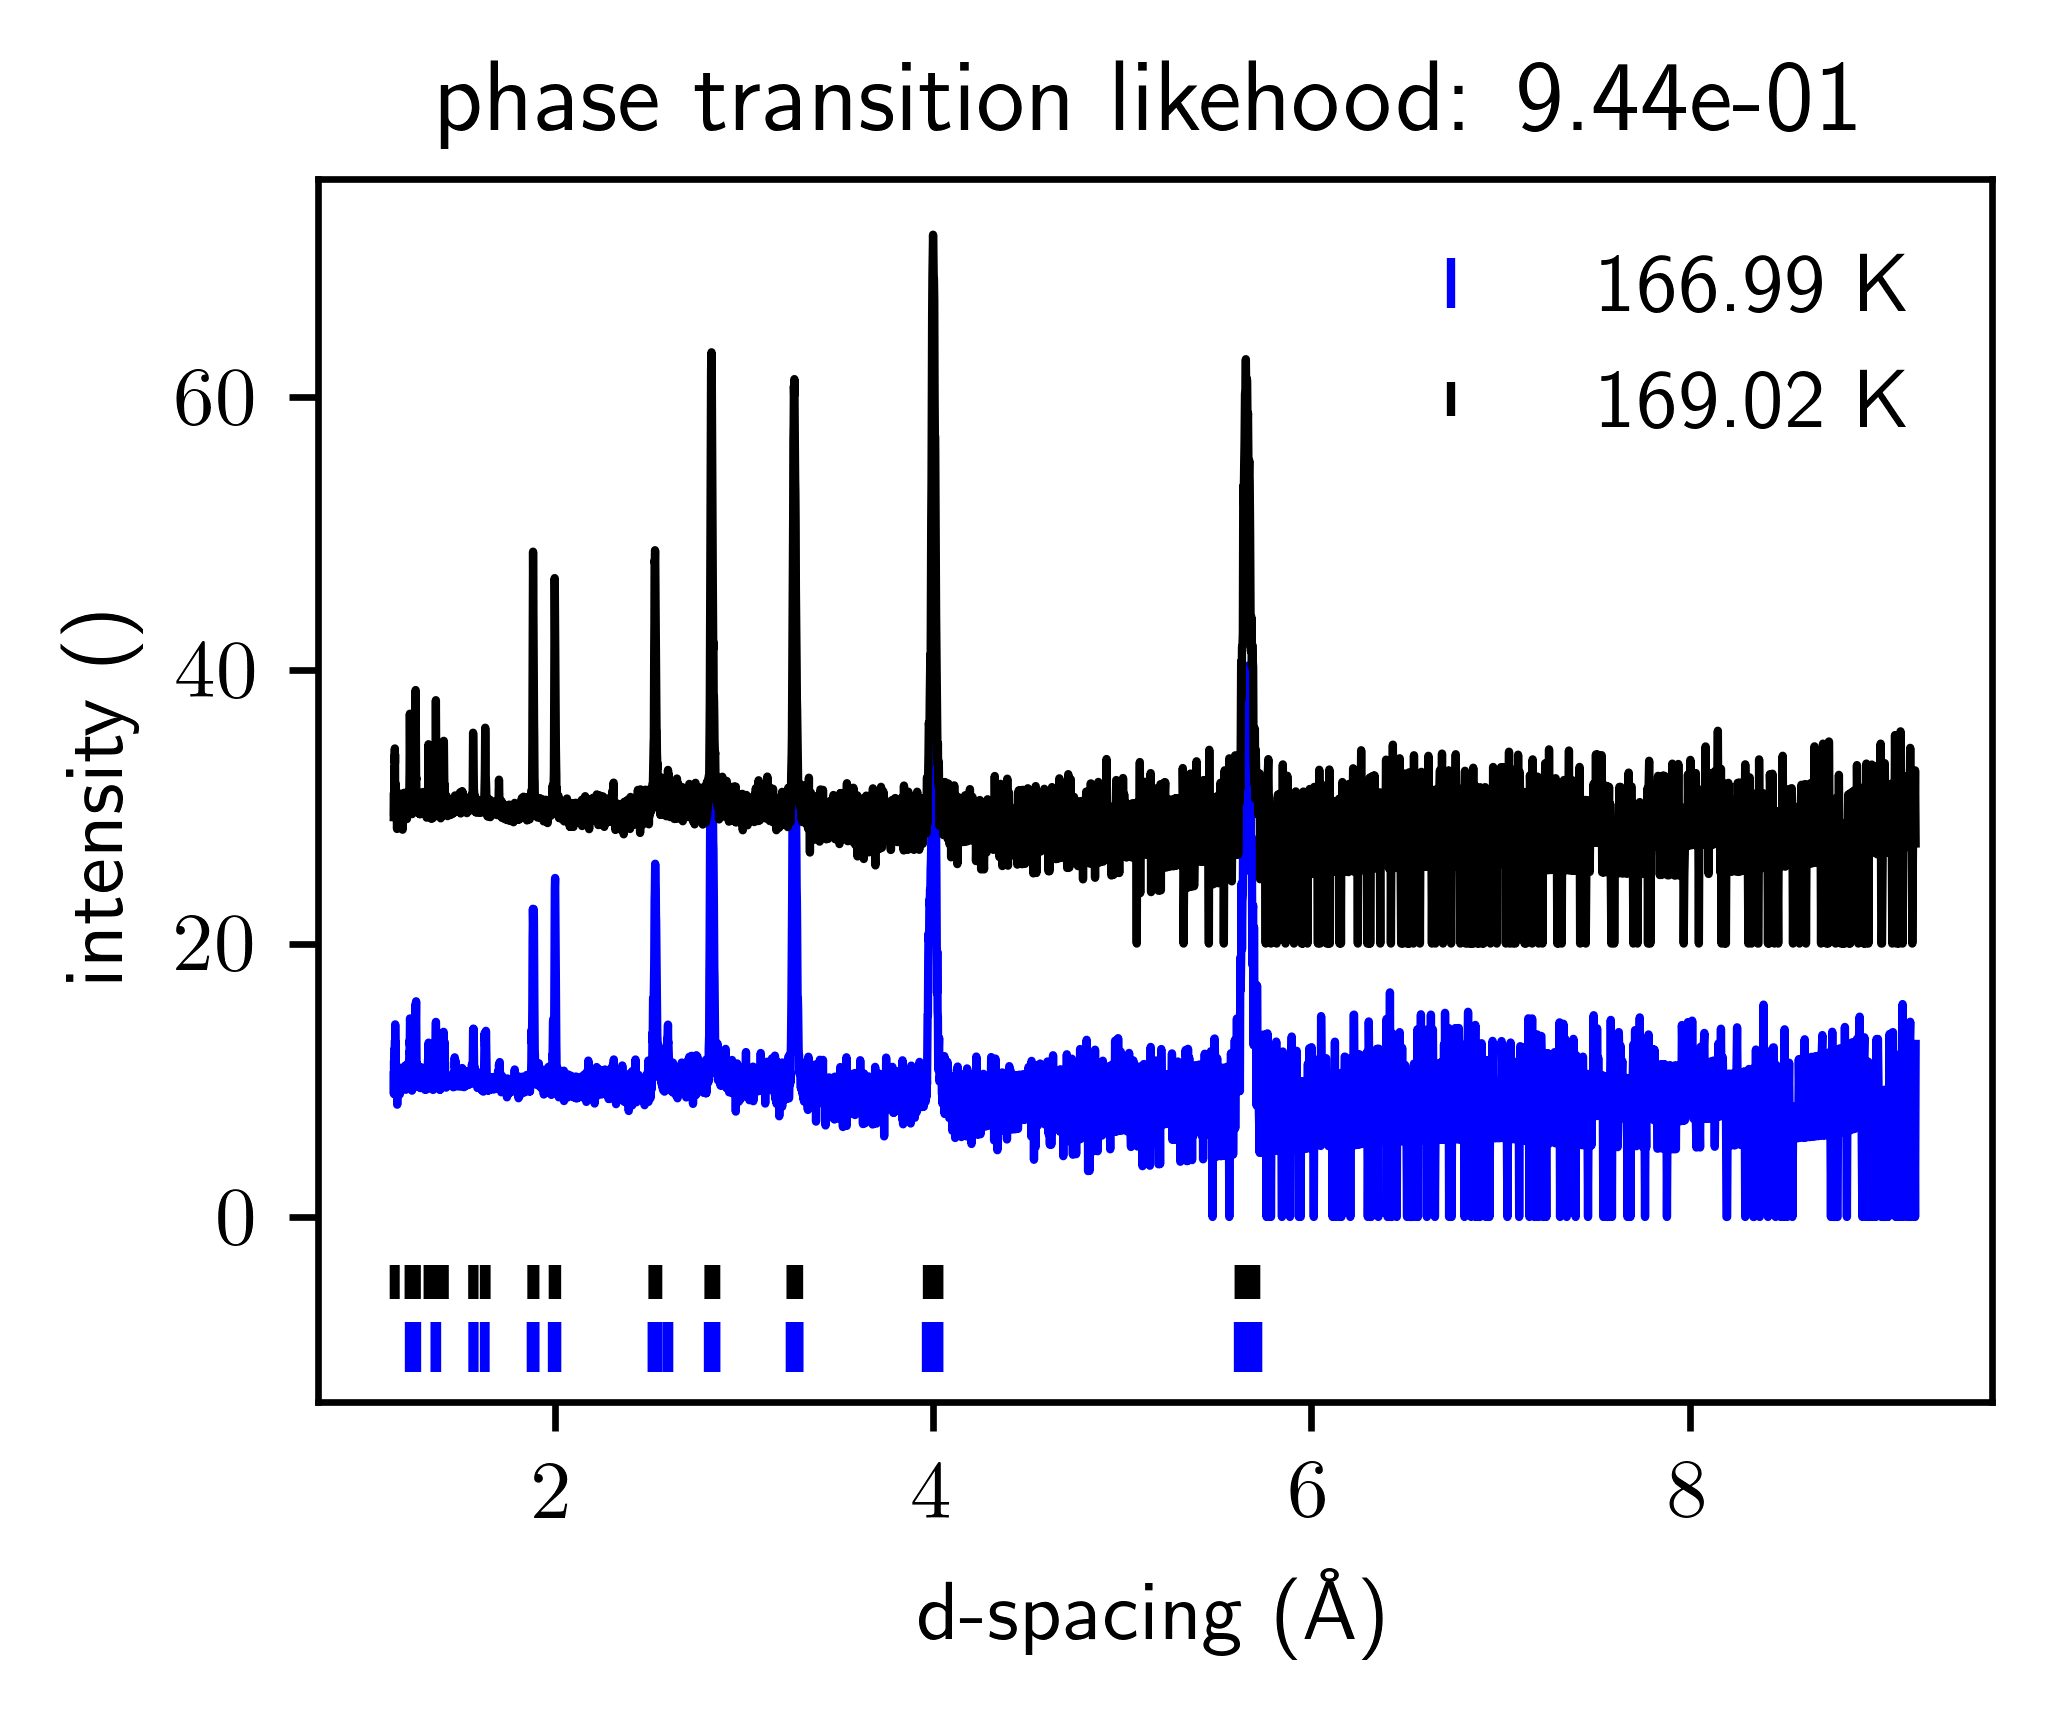

In [4]:
figsize(3.6, 2.7)
temp=167
title = 'Q4/Figs/phasetransitioprobn_%3d_K' %(temp)
likehood = cal_likehood(intsy, temps, temp, bin_cs = dd_cs, figtitle=title, gamma=5)
print('The likehood of a phase transtion at %d K is %3.2e' %(temp, likehood))

219.02625 220.995166667
The likehood of a phase transtion at 220 K is 1.69e-15


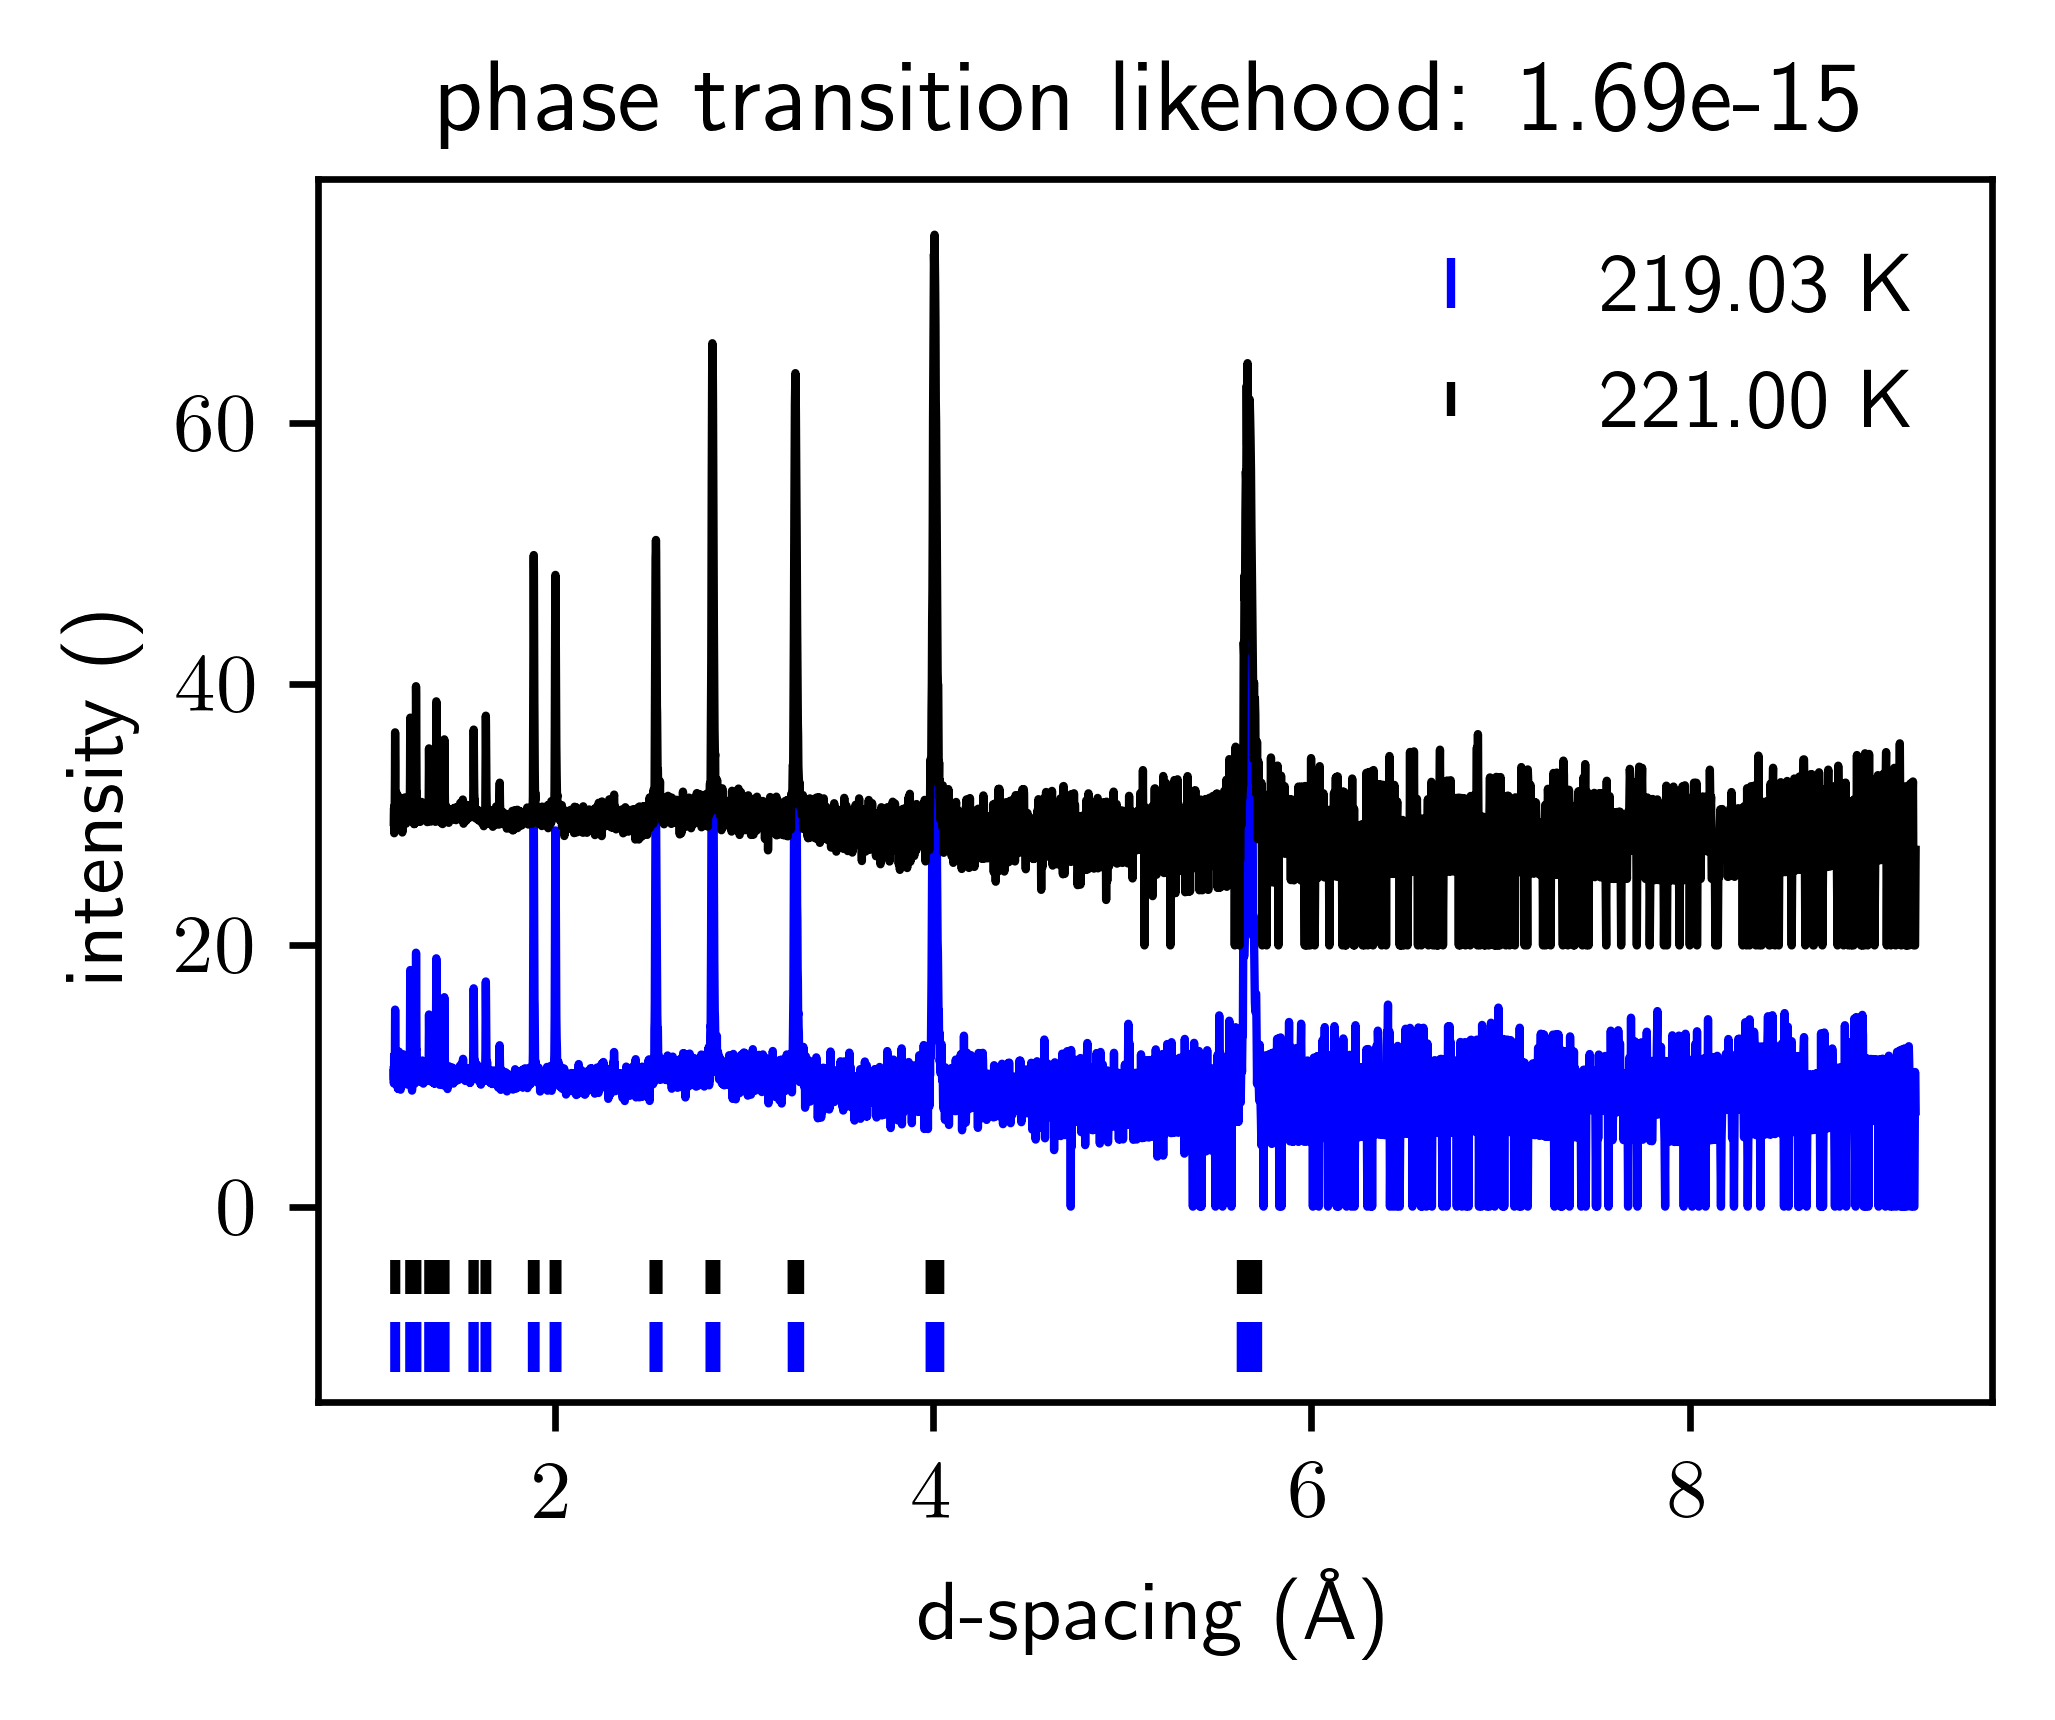

In [5]:
figsize(3.6, 2.7)
temp=220
title = 'Q4/Figs/phasetransitioprobn_%3d_K' %(temp)
likehood = cal_likehood(intsy, temps, temp, bin_cs = dd_cs, figtitle=title)
print('The likehood of a phase transtion at %d K is %3.2e' %(temp, likehood))

In [6]:
# slightly change the code to calcuate the likehood from all temperatures. 
likeh = cal_NNlikehood_fullT(intsy, gamma=5)

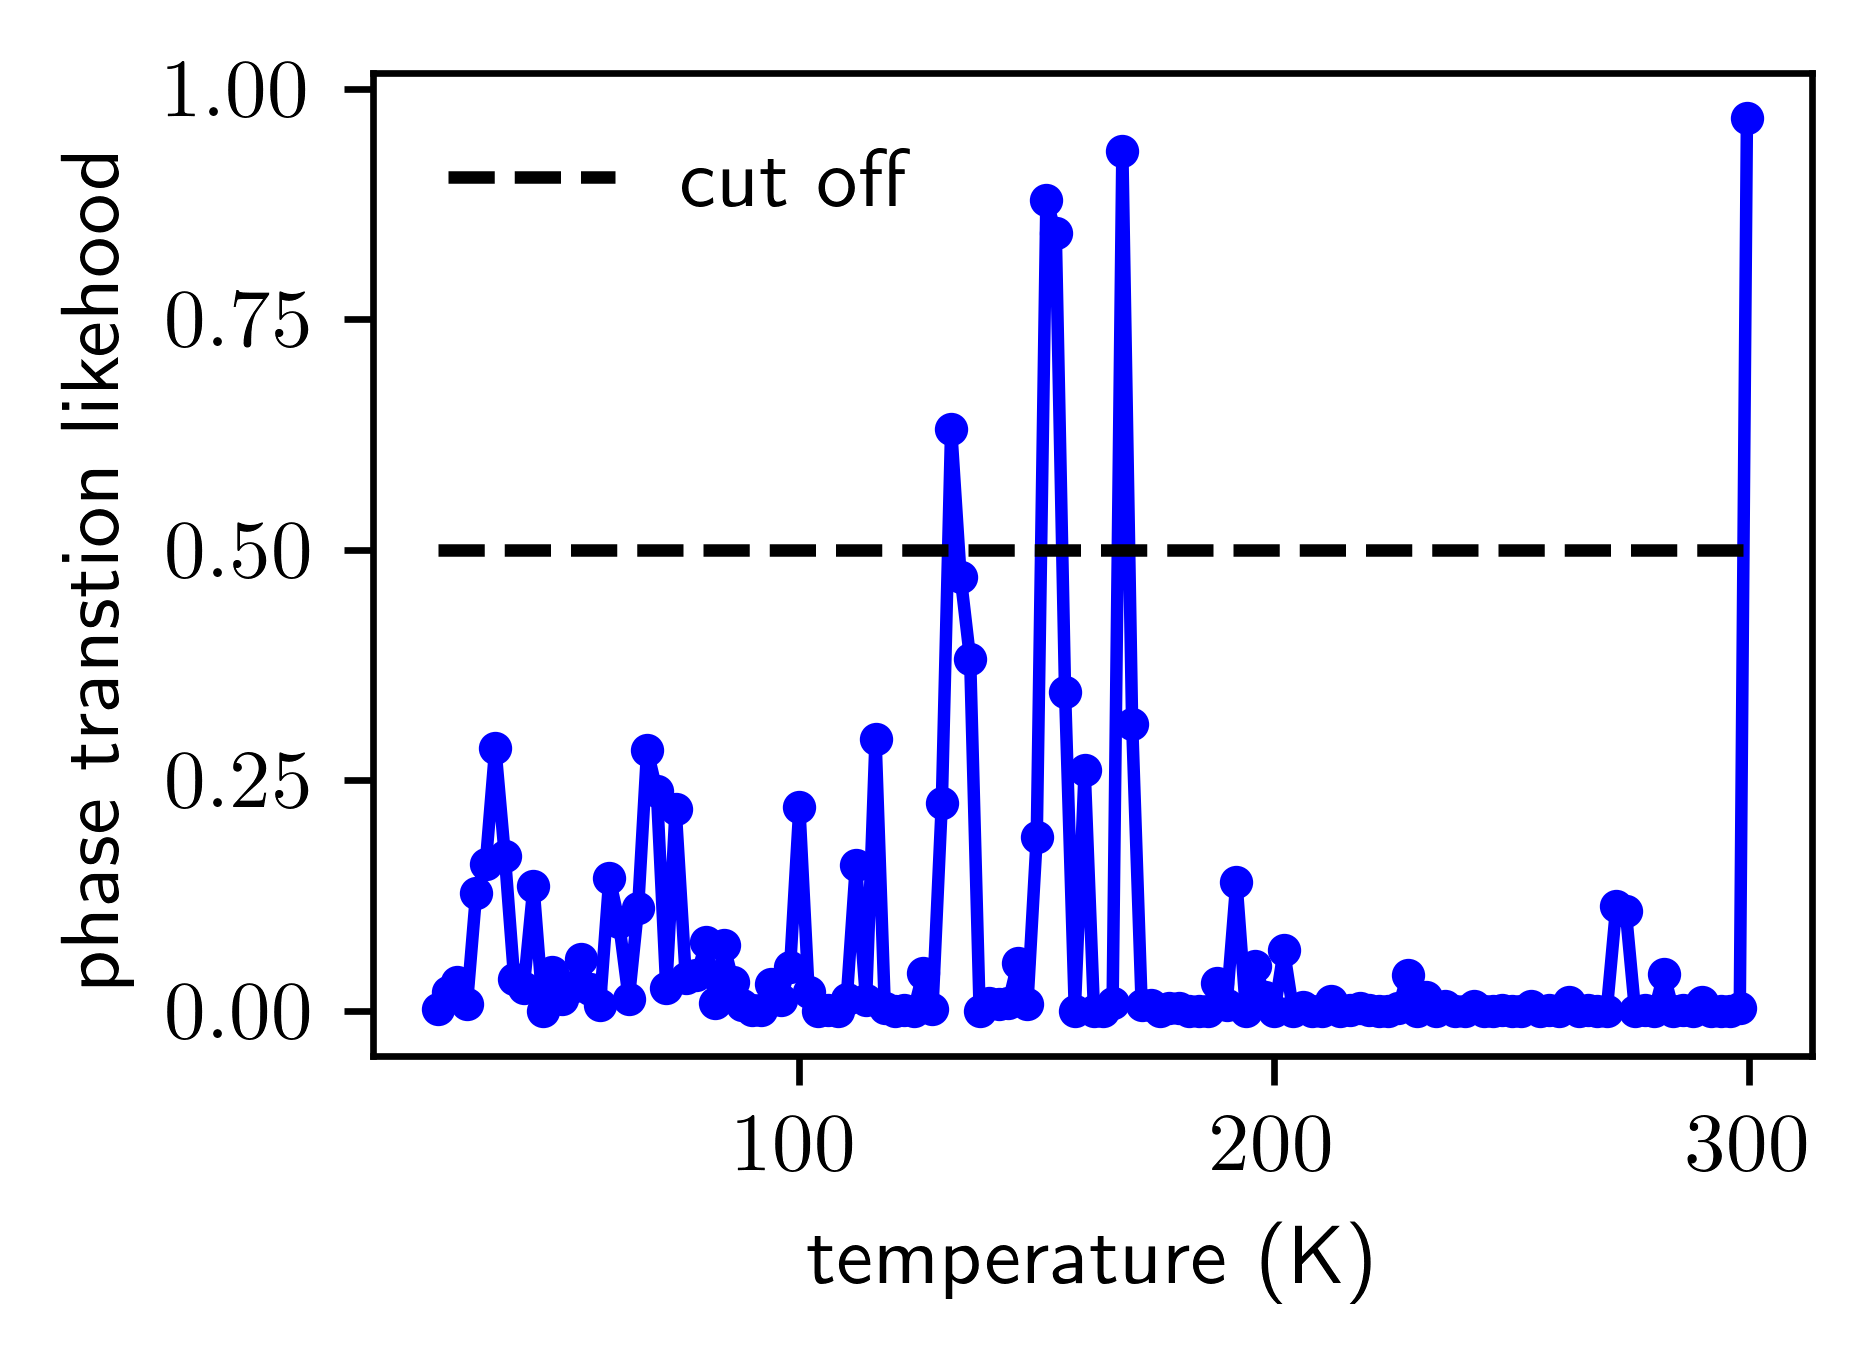

In [7]:
figsize(3.2, 2.4)
plt.plot(temp_cs, np.asarray(likeh), '.-', color='blue')
plt.plot(temp_cs, np.full(len(temp_cs), 0.5), "--", color='black', label='cut off')
plt.ylabel('phase transtion likehood')
plt.xlabel('temperature (K)')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('Q4/Figs/PhaseTransition_Likehood_allT')